# Demo: Mapping SIMP 0136 with NIRSpec

In this tutorial, we will demonstrate how to use `spectralmap` to analyze time-series observations. We will use a sequence of NIRSpec observations of the brown dwarf SIMP 0136 to recover a spectroscopic map of its surface.

**We will cover:**
1. Loading and preprocessing the lightcurve data.
2. Inverting the lightcurves to obtain surface maps.
3. Clustering the map pixels to identify distinct spectral regions.
4. Extracting and analyzing the spectra of these regions.

Let's get started!

In [1]:
from __future__ import annotations

from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,    
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.8,
    "figure.dpi": 300,
    "figure.figsize": (3.5, 2.5),  # ApJ column width ~3.5 in; double column ~7 in
})

In [2]:
import numpy as np
print(np.__version__)
np.bool = bool
import starry
starry.config.lazy = False  # disable lazy evaluation
starry.config.quiet = True  # disable warnings
map = starry.Map(ydeg=4)

1.21.1


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/starry/_core/ops/limbdark/base_op.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
A=map.design_matrix(theta=np.linspace(0, 360, 100))

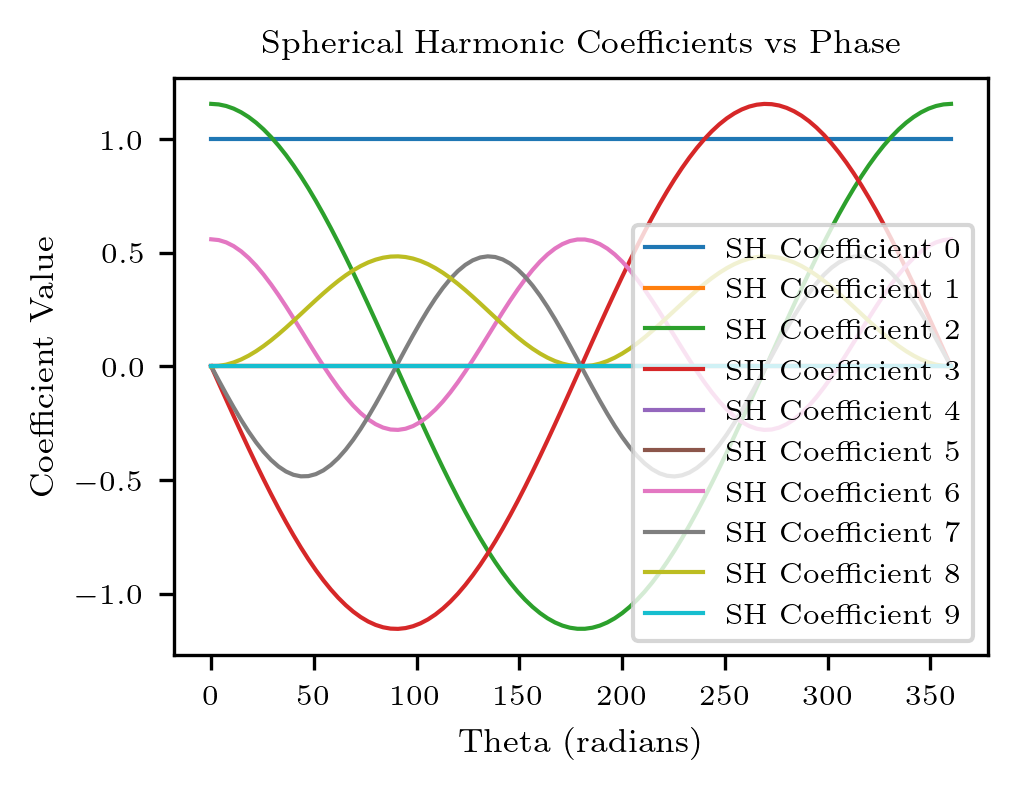

In [4]:
theta_grid = np.linspace(0, 360, 100)
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(theta_grid, A[:, i], label=f'SH Coefficient {i}')
plt.legend()
plt.xlabel('Theta (radians)')
plt.ylabel('Coefficient Value')
plt.title('Spherical Harmonic Coefficients vs Phase')
plt.show()

In [5]:
import os
import matplotlib.pyplot as plt

import spectralmap
print(f"spectralmap version: {spectralmap.__version__}")

spectralmap version: 0.1.0


## 1. Load Data
Before we apply spectralmap to a spectroscopic time series, we will need to read them in, sort them by phase, and normalize the flux.

In [6]:
import numpy as np

# 1. Load the data files
theta = np.load("data/SIMP0136_NIRSpec.npz")["theta"]
wl = np.load("data/SIMP0136_NIRSpec.npz")["wl"]
flux_raw = np.load("data/SIMP0136_NIRSpec.npz")["flux_raw"]
flux_err_raw = np.load("data/SIMP0136_NIRSpec.npz")["flux_err_raw"]

# 2. Normalize the lightcurves
# We normalize by the mean amplitude over time for each wavelength
amplitudes = np.nanmean(flux_raw, axis=1)
flux = (flux_raw.T / amplitudes).T
flux_err = (flux_err_raw.T / amplitudes).T

print(f"Loaded data with shape: {flux.shape} (wavelengths, time points)")
print(f"Wavelength range: {wl.min():.2f}, {wl.max():.2f} microns")
print(f"Phase range: {theta.min():.2f}, {theta.max():.2f} radians")

Loaded data with shape: (359, 24) (wavelengths, time points)
Wavelength range: 0.92, 5.27 microns
Phase range: 0.00, 345.00 radians


## 2. Inversion with SpectralMap

First, we organize the data into a `LightCurveData` object. We must specify the inclination of the object (here assumed to be 80 degrees).

In [7]:
from spectralmap.mapping import LightCurveData
data = LightCurveData(theta=theta, flux=flux[:, :], flux_err=flux_err[:, :], inc=80)

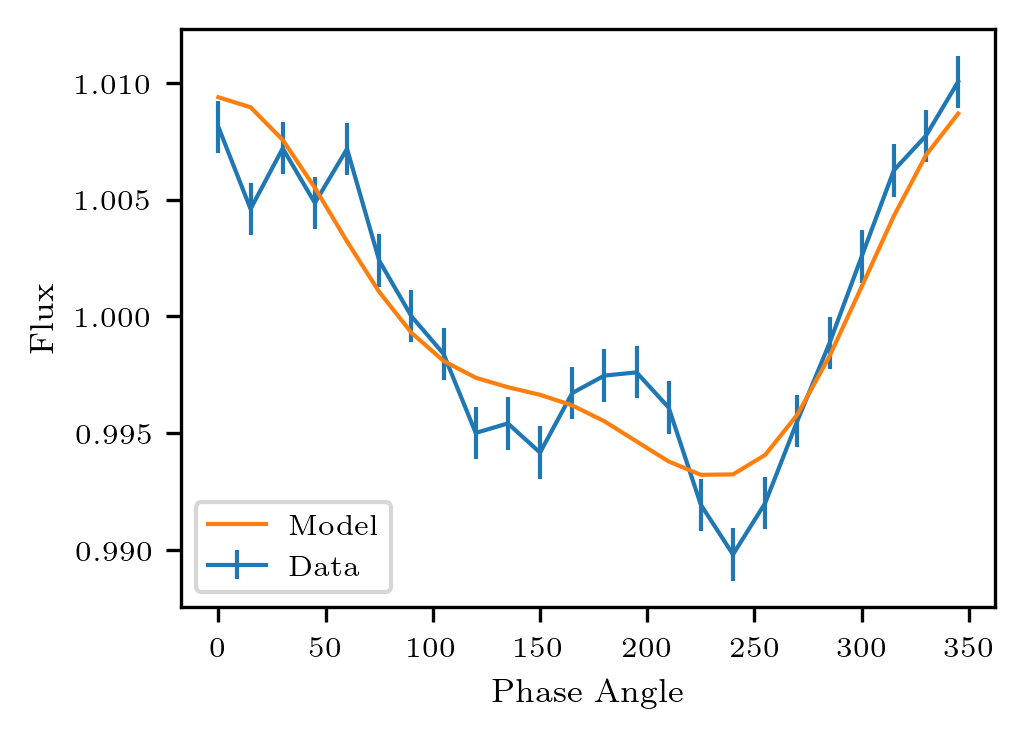

In [8]:
from spectralmap.mapping import make_map
map = make_map(mode='rotational',  map_res=30, ydeg=2, inc=80)
i_to_plot = 10  # Index of wavelength to plot
map.solve_posterior(data.flux[i_to_plot], data.flux_err[i_to_plot], data.theta, verbose=True)
map.plot_lightcurve()

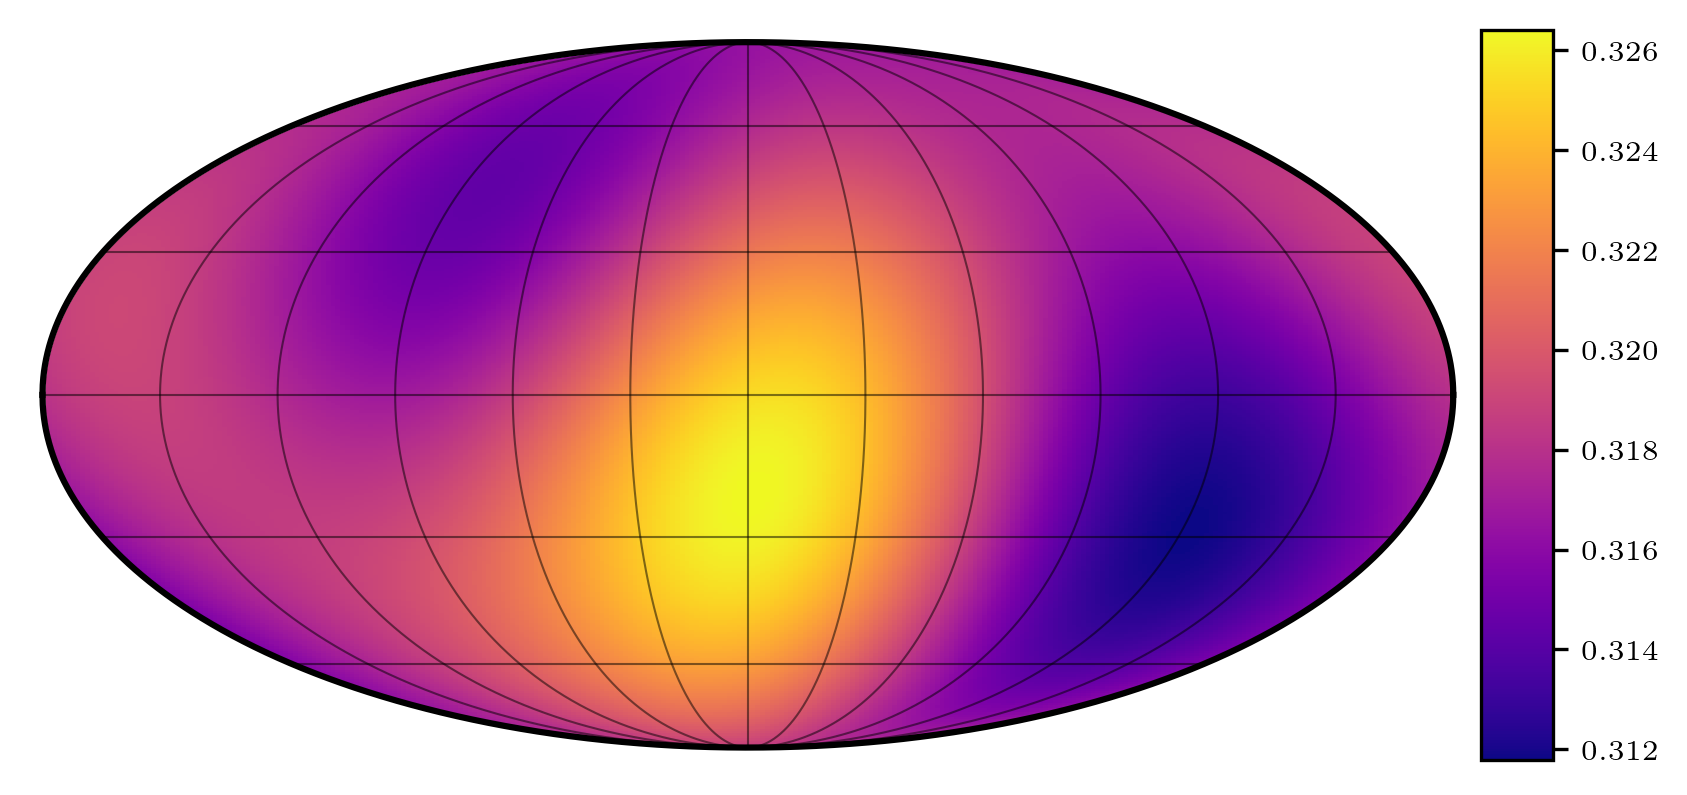

array([[ 1.        , -0.00171457,  0.00664839, -0.0019228 ,  0.00357425,
        -0.00360796,  0.00478719,  0.00247404, -0.00132699]])

In [9]:
map.draw(plot=True, projection="moll", grid=True, colorbar=True, n_samples=1)

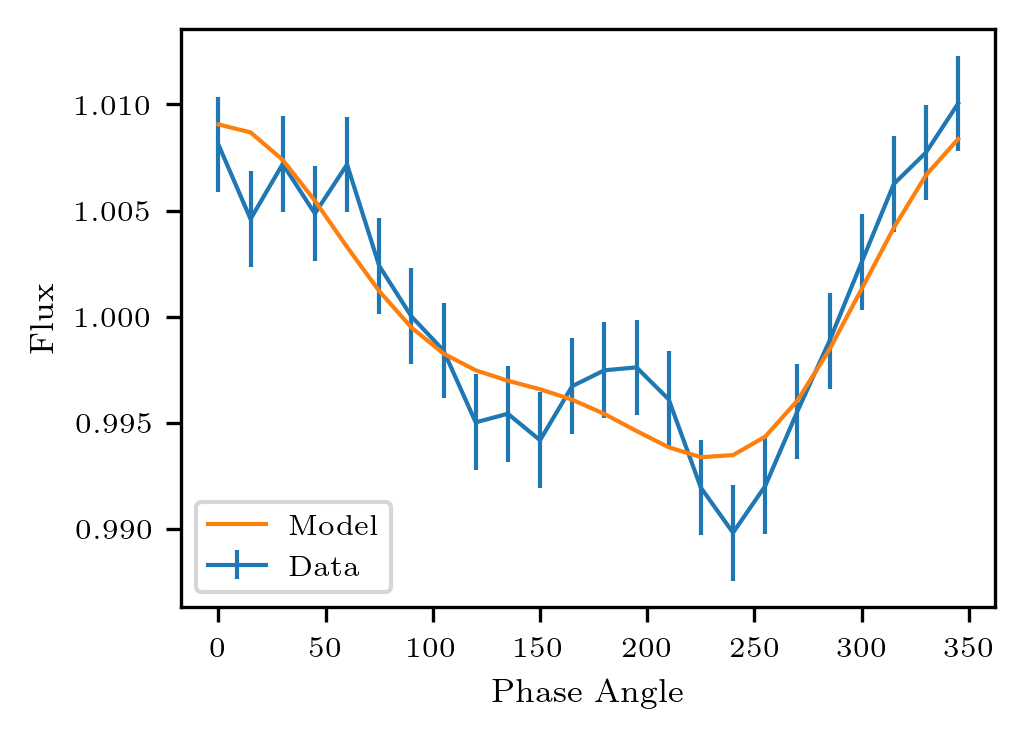

In [10]:
map.solve_posterior(data.flux[i_to_plot], None, data.theta, verbose=True)
map.plot_lightcurve()

### Find Optimal Map Complexity
We now solve for the maps. Since we don't know the complexity of the surface beforehand, we test spherical harmonic degrees ranging from `ydeg=2` to `ydeg=10`. The algorithm will automatically select the degree that best fits the data without overfitting (using the Bayesian Information Criterion).

In [11]:
# Marginalize over spherical harmonic degree to find balance model complexity and fit quality
from spectralmap.mapping import make_maps
maps = make_maps(mode='rotational', map_res=30, ydegs=np.arange(2, 10))
w_all, I_all_wl, I_cov_all_wl = maps.marginalized_maps(data)

ydeg:   0%|          | 0/8 [00:00<?, ?it/s, wl 1/359]

ydeg: 100%|██████████| 8/8 [00:15<00:00,  1.91s/it, wl 359/359]


lambda=None: Best-evidence wavelength counts by ydeg: ydeg=2: 237, ydeg=3: 49, ydeg=4: 30, ydeg=5: 8, ydeg=6: 20, ydeg=7: 11, ydeg=8: 2, ydeg=9: 2


## 3. Visualize the Maps
Let's take a look at the recovered maps for a few wavelengths to see how the surface features change.

In [12]:
# for i, ydeg in enumerate(ydeg_best):
#     if ydeg <= 5:
#         plt.figure()
#         plt.imshow(I_all_wl[i].reshape((30, 30)), origin='lower')
#         plt.title(f"Wavelength {wl[i]: .2f}: best ydeg = {ydeg}")


## 4. Spectral Extraction
We convert the retrieved intensity maps ($I$) back into physical flux units ($F$) and calculate the associated variances. This gives us the spatially-resolved spectra.

In [13]:
F_all_wl = I_all_wl * amplitudes[:, None] *np.pi
F_cov_all_wl = I_cov_all_wl * (np.pi * amplitudes[:, None, None])**2
F_var_all_wl = np.diagonal(F_cov_all_wl, axis1=1, axis2=2)

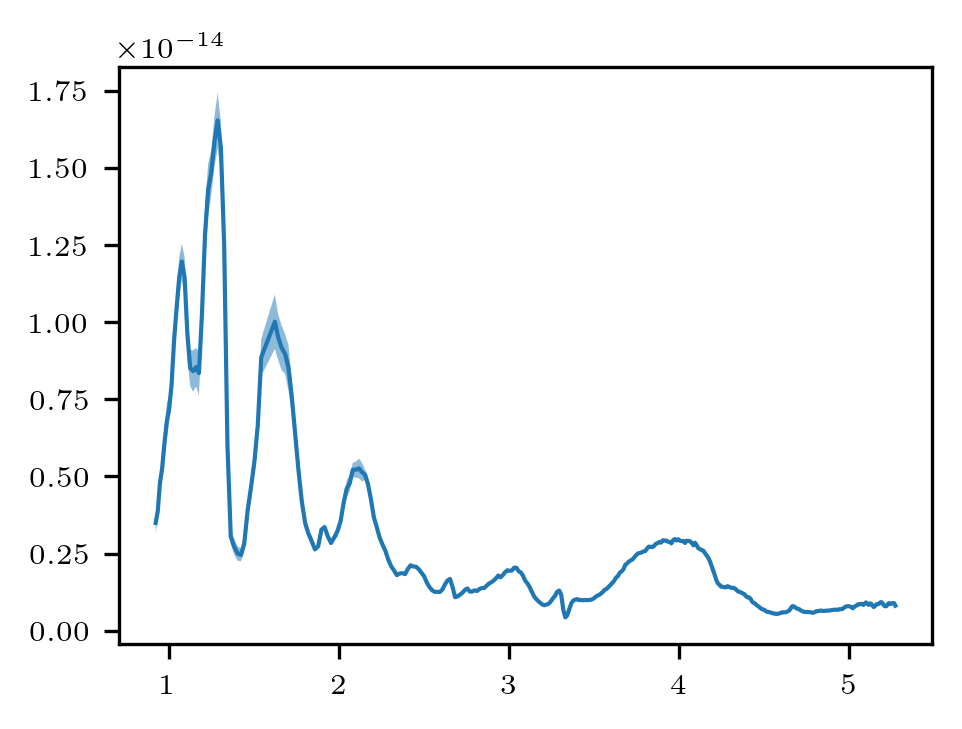

In [14]:
import matplotlib.pyplot as plt
i_grid = 300
plt.plot(wl[:], F_all_wl[:, i_grid])
plt.fill_between(wl[:], F_all_wl[:, i_grid] - np.sqrt(F_var_all_wl[:, i_grid]), F_all_wl[:, i_grid] + np.sqrt(F_var_all_wl[:, i_grid]), alpha=0.5)

## 5. Clustering and Regional Identification
To make sense of the map, we group pixels that show similar spectral behavior using a clustering algorithm. This helps us identify distinct "regions" or features on the object's surface.

-1 432
0 100
1 69
2 98


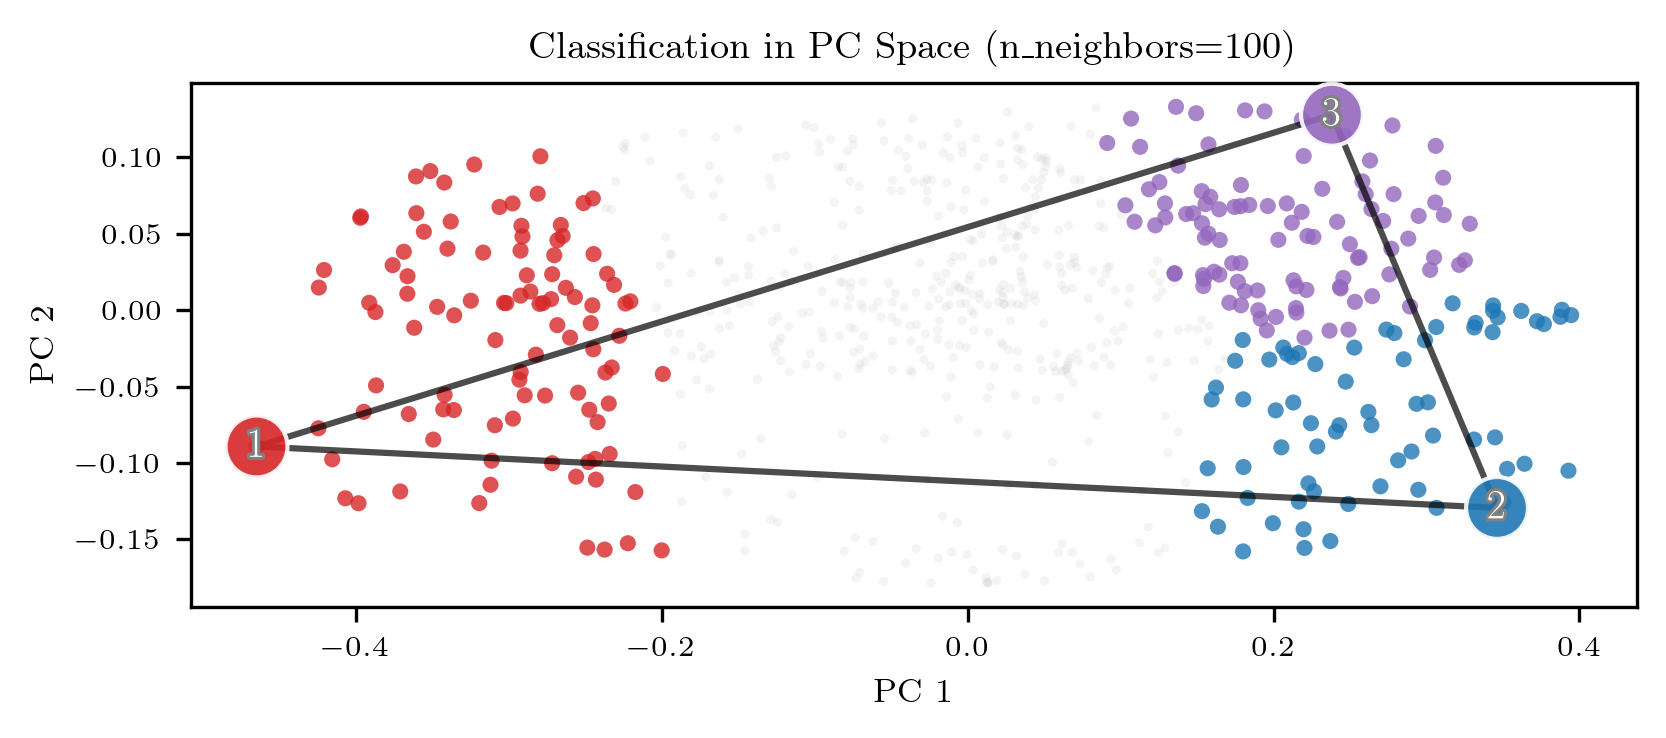

In [15]:
from spectralmap.cluster import find_clusters
F_regionals, F_regional_errs, labels = find_clusters(F_all_wl, F_cov_all_wl, n_neighbors=100, n_corners=3)
N = len(F_regionals)

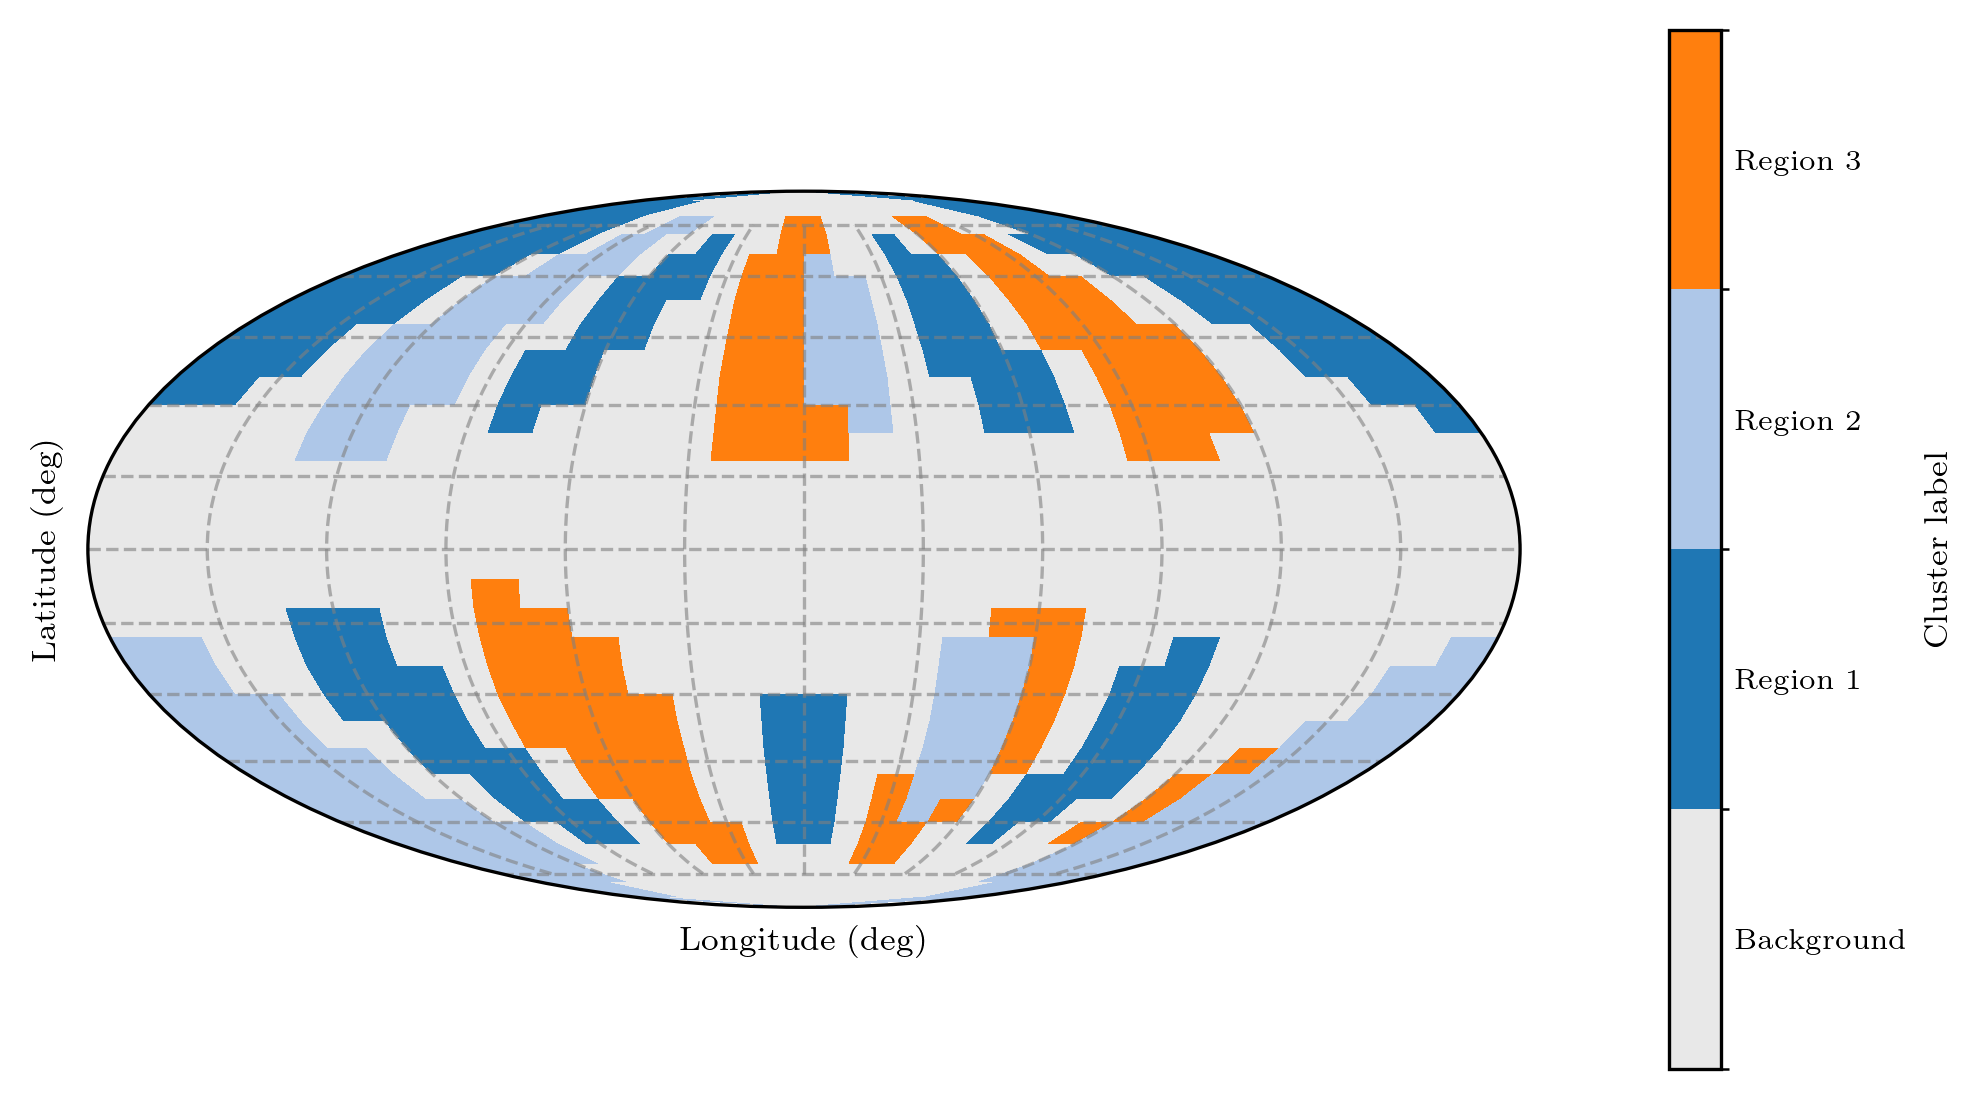

In [ ]:
from spectralmap.utilities import plot_mollweide_labels
from matplotlib import colors as mcolors


colors_list = ['#E8E8E8']  # Background
region_colors = plt.get_cmap('tab10').colors
for i in range(N - 1):
    colors_list.append(region_colors[i % len(region_colors)])

cluster_names = ["Background"] + [f"Region {i+1}" for i in range(N - 1)]
cmap = mcolors.ListedColormap(colors_list)

fig, ax, pcm, cb = plot_mollweide_labels(
    labels_masked=labels,      # should be ints 0..N-1 on masked pixels
    moll_mask=maps.moll_mask,
    map_res=map.map_res,
    cmap=cmap,
    names=cluster_names
)

output_dir = "paper_plots"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "S0136_recovered_regions.pdf")

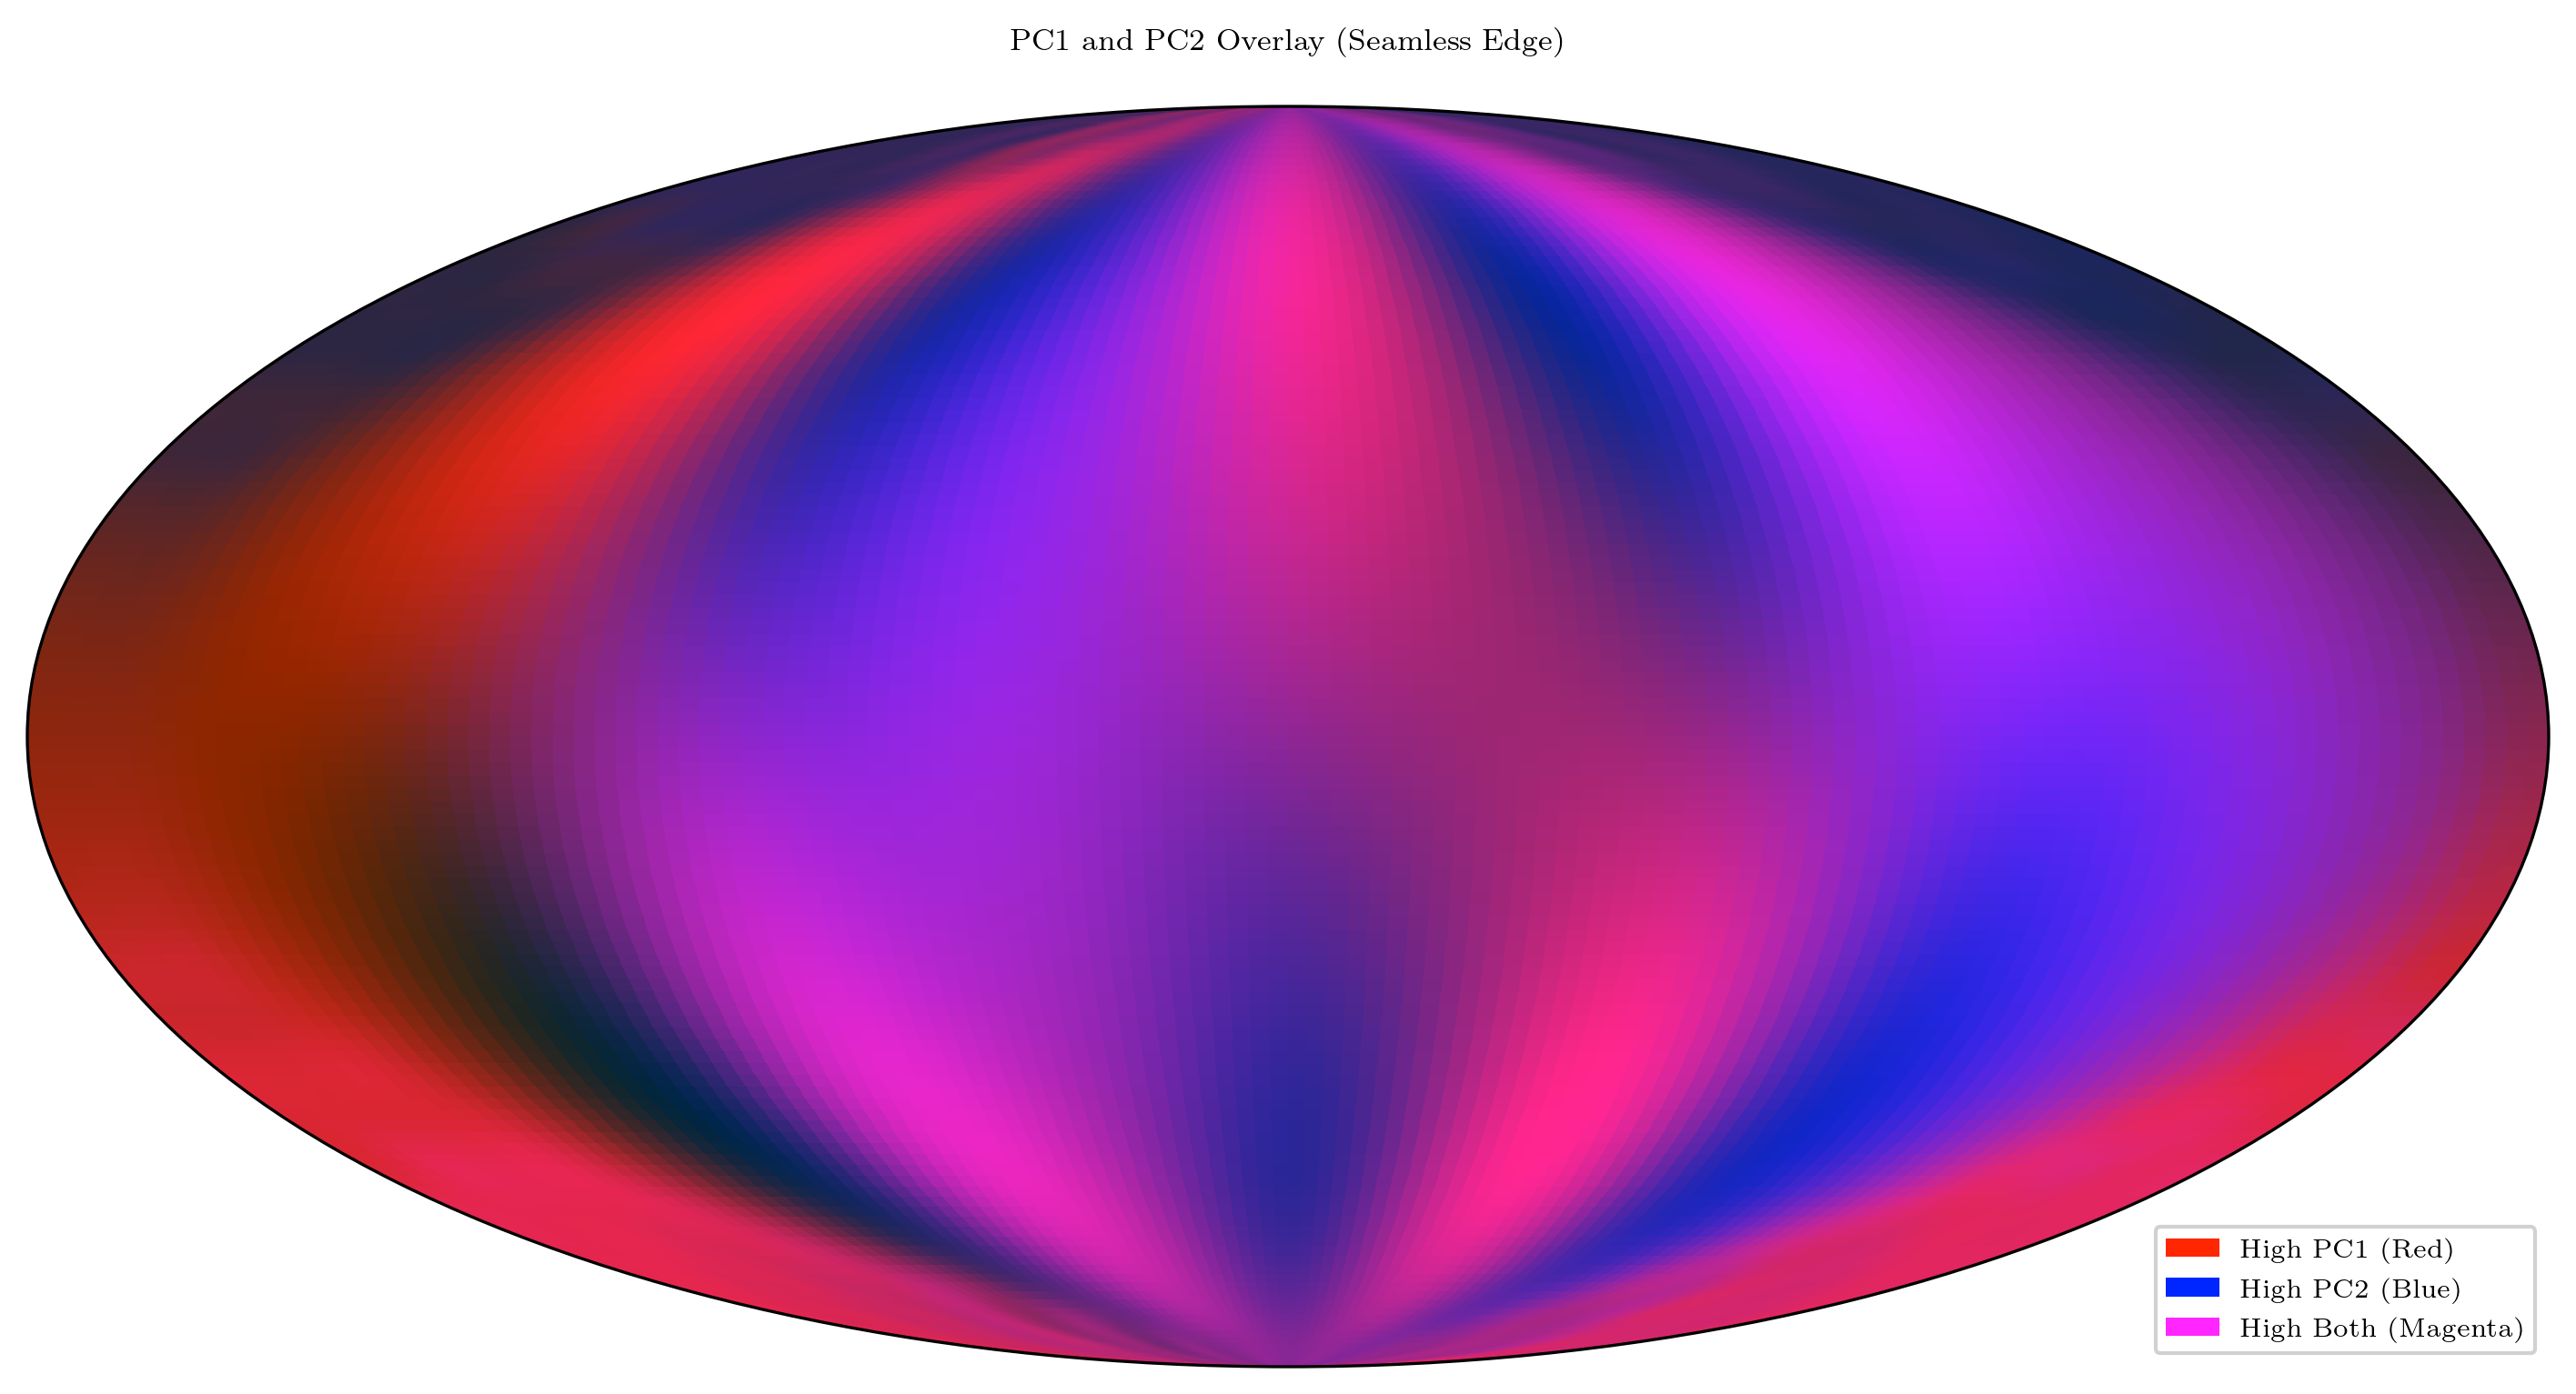

In [17]:
from sklearn.decomposition import PCA
from spectralmap.utilities import expand_moll_values, plot_mollweide_rgb_perfect_edges
pca = PCA(n_components=2)
PCs = pca.fit_transform(np.log(F_all_wl).T)  # shape: (n_wavelengths, 2)
pc1_scores = PCs[:, 0]
pc2_scores = PCs[:, 1]

mask_2d = maps.moll_mask
fig, ax = plot_mollweide_rgb_perfect_edges(pc1_scores, pc2_scores, mask_2d, upsample=4)
plt.show()

## 6. Results
Finally, we visualize the identified clusters on the map and plot the mean spectrum for each region.

Plot saved to paper_plots/S0136_recovered_spectra.pdf


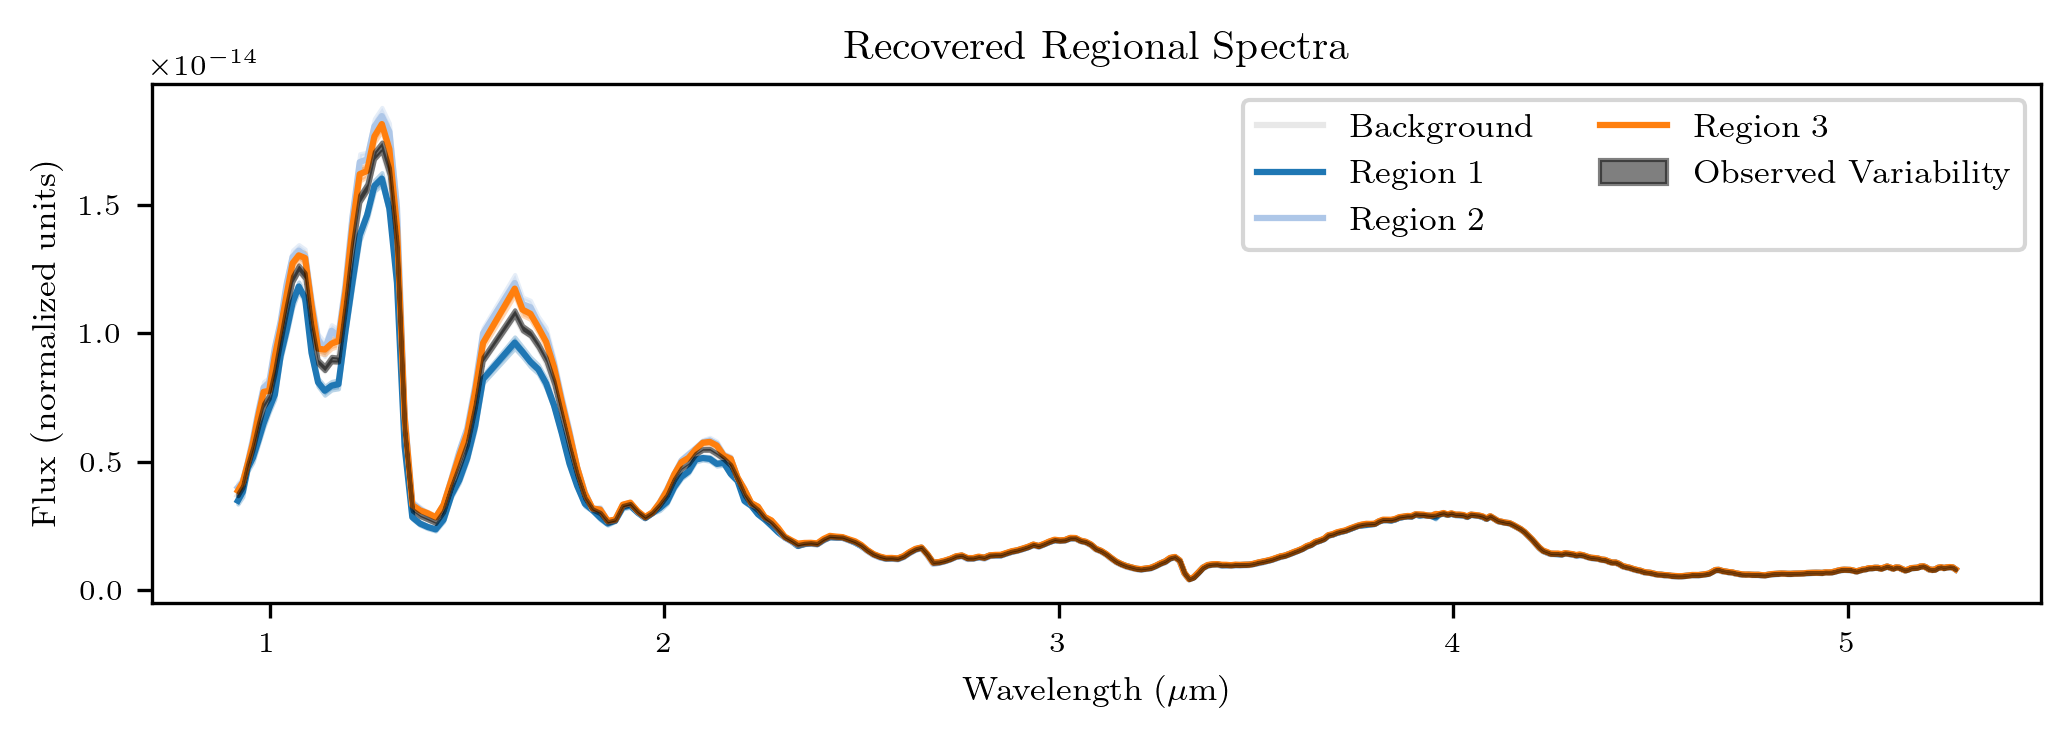

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import os

fig, ax = plt.subplots(figsize=(7, 2.5))

# Plot the recovered spectra for each region
for i in range(N):
    mean_flux = F_regionals[i]
    error_flux = F_regional_errs[i] # Fixed variable name
    color = colors_list[i]
    label = cluster_names[i]
    
    ax.plot(wl, mean_flux, label=f"{label}", color=color, linewidth=1.5)
    ax.fill_between(wl, 
                    mean_flux - error_flux, 
                    mean_flux + error_flux, 
                    alpha=0.3, color=color)
    
# Overlay the range of the observed time-series variability
time_series = np.sort(flux_raw.T, axis=0)
ax.fill_between(wl, time_series[0, :],
            time_series[-1, :], color='black', alpha=0.5, zorder=10, label="Observed Variability")

# Formatting
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel("Flux (normalized units)")
ax.set_title("Recovered Regional Spectra", fontsize=10)
ax.legend(fontsize=8, loc='upper right', ncol=2)

plt.tight_layout()

output_dir = "paper_plots"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "S0136_recovered_spectra.pdf")
plt.savefig(output_path, dpi=600)
print(f"Plot saved to {output_path}")

plt.show()